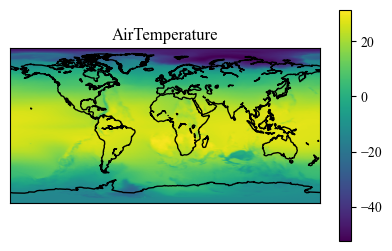

In [13]:
import sys
# sys.path.append('./satclip')
import matplotlib.pyplot as plt
import torch
# from load import get_satclip
from mpl_toolkits.basemap import Basemap
from urllib import request
import numpy as np
import pandas as pd
import io
import torch
from torch.utils.data import TensorDataset, random_split


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Automatically select device
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim, dim_hidden, num_layers, out_dims):
        super(MLP, self).__init__()

        layers = []
        layers += [nn.Linear(input_dim, dim_hidden, bias=True), nn.ReLU()] # Input layer
        layers += [nn.Linear(dim_hidden, dim_hidden, bias=True), nn.ReLU()] * num_layers # Hidden layers
        layers += [nn.Linear(dim_hidden, out_dims, bias=True)] # Output layer

        self.features = nn.Sequential(*layers)

    def forward(self, x):
        return self.features(x)

def convert_to_lat_lon(data):
    """
    Converts a list of numbers between 0 and 64799 to a list of latitudes and longitudes within the range [-89, 90] and [-180, 179].

    Args:
        data (list): A list of numbers between 0 and 64799.

    Returns:
        list: A list of tuples representing latitudes and longitudes.
    """

    latitudes = []
    longitudes = []

    for number in data:
        # Convert number to latitude and longitude coordinates
        latitude = (number // 360) - 89
        longitude = (number % 360) - 180

        # Append coordinates to lists
        latitudes.append(latitude)
        longitudes.append(longitude)

    return list(zip(latitudes, longitudes))

def calculate_lat_lon(row):
    # 这里是你的函数，我假设它是func
    # import ipdb; ipdb.set_trace()
    lat, lon = convert_to_lat_lon([row.name])[0]
    lat = lat + 0.5
    lon = lon + 0.5
    return pd.Series({'lat': lat, 'lon': lon})

def get_air_temp_data(pred="temp",
                      norm_y=True,
                      norm_x=True
                      ):
    '''
    Download and process the Global Air Temperature dataset (more info: https://www.nature.com/articles/sdata2018246)

    Parameters:
    pred = numeric; outcome variable to be returned; choose from ["temp", "prec"]
    norm_y = logical; should outcome be normalized
    norm_min_val = integer; choice of [0,1], setting whether normalization in range[0,1] or [-1,1]

    Return:
    coords = spatial coordinates (lon/lat)
    x = features at location
    y = outcome variable
    '''
    #   url = 'https://springernature.figshare.com/ndownloader/files/12609182'
    #   url_open = request.urlopen(url)
    
    # inc = np.array(pd.read_csv(io.StringIO(url_open.read().decode('utf-8'))))
    # inc = pd.read_csv('stat_rain/avg_day.csv',names=['precipitation_value'])
    inc = pd.read_csv('../data/temperature_avg_day.csv',names=['temperature'])
    # 定义函数来计算经纬度

    # 计算经纬度并添加到DataFrame
    inc[['lat', 'lon']] = inc.apply(calculate_lat_lon, axis=1)
    inc = np.array(inc)
    y = inc[:,0].reshape(-1)
    # y = y / 8
    coords = inc[:,1:]
    # import ipdb; ipdb.set_trace()
    # coords = coords[:,::-1]
    y_mean = np.mean(y)
    y_std = np.std(y)
    y = (y - y_mean) / y_std

    return torch.tensor(coords.copy()),  torch.tensor(y), y_mean, y_std




coords, y, y_mean, y_std = get_air_temp_data()

# import matplotlib.pyplot as plt
# from mpl_toolkits.basemap import Basemap

fig, ax = plt.subplots(1, figsize=(5, 3))

m = Basemap(projection='cyl', resolution='c', ax=ax)
m.drawcoastlines()
scatter = ax.scatter(coords[:,1], coords[:,0], c=y*y_std+y_mean, s=5)
ax.set_title('AirTemperature')

# 添加colorbar
cbar = plt.colorbar(scatter)
# cbar.set_label('wind')

plt.show()

In [16]:
print(y)
print(y.max())
print(y.min())

tensor([-0.9667, -0.9669, -0.9671,  ..., -2.6517, -2.6508, -2.6500],
       dtype=torch.float64)
tensor(1.2908, dtype=torch.float64)
tensor(-2.9584, dtype=torch.float64)


torch.Size([64800, 2])
torch.Size([64800, 512])


Text(0.5, 1.0, 'Train-Test Split')

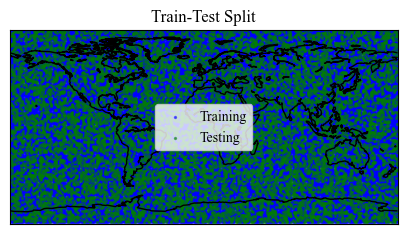

In [17]:

# import torch
from geoclip import LocationEncoder

model = LocationEncoder()
model.load_state_dict(
        torch.load('location_encoder_weights.pth')
)
model.to(device)
model.eval()
# import ipdb; ipdb.set_trace()
# print(coords.dtype)
# coords = coords.double()
with torch.no_grad():
  # x  = model(coords.double().to(device)).detach().cpu()
  # x  = model(coords.to(device)).detach().cpu()
  x  = model(coords.float().to(device)).detach().cpu()

print(coords.shape)
print(x.shape)


dataset = TensorDataset(coords, x, y)

# train_size = int(0.8 * len(dataset))
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

coords_train, x_train, y_train = train_set.dataset.tensors[0][train_set.indices], train_set.dataset.tensors[1][train_set.indices], train_set.dataset.tensors[2][train_set.indices]
coords_test, x_test, y_test = test_set.dataset.tensors[0][test_set.indices], test_set.dataset.tensors[1][test_set.indices], test_set.dataset.tensors[2][test_set.indices]

fig, ax = plt.subplots(1, figsize=(5, 3))

m = Basemap(projection='cyl', resolution='c', ax=ax)
m.drawcoastlines()
ax.scatter(coords_train[:,1], coords_train[:,0], c='blue', s=2, label='Training',alpha=0.5)
ax.scatter(coords_test[:,1], coords_test[:,0], c='green', s=2, label='Testing',alpha=0.5)
ax.legend()
ax.set_title('Train-Test Split')


In [20]:
print(y_test)
print(y_std)
print(y_mean)
print(y_test*y_std+y_mean)


tensor([ 1.0501,  0.9904,  1.1129,  ...,  0.7732, -0.0318, -1.2752],
       dtype=torch.float64)
19.70961201276809
5.9174608941321285
tensor([ 26.6147,  25.4381,  27.8521,  ...,  21.1562,   5.2911, -19.2163],
       dtype=torch.float64)


Epoch 250, MSE Loss: 0.0702
Epoch 250, MAE Loss: 0.1945
early_stop_counter: 0
Epoch 500, MSE Loss: 0.0313
Epoch 500, MAE Loss: 0.1266
early_stop_counter: 0
Epoch 750, MSE Loss: 0.0219
Epoch 750, MAE Loss: 0.1059
early_stop_counter: 0
Epoch 1000, MSE Loss: 0.0174
Epoch 1000, MAE Loss: 0.0949
early_stop_counter: 0
Epoch 1250, MSE Loss: 0.0143
Epoch 1250, MAE Loss: 0.0864
early_stop_counter: 0
Epoch 1500, MSE Loss: 0.0123
Epoch 1500, MAE Loss: 0.0803
early_stop_counter: 0
Epoch 1750, MSE Loss: 0.0108
Epoch 1750, MAE Loss: 0.0760
early_stop_counter: 12
Epoch 2000, MSE Loss: 0.0097
Epoch 2000, MAE Loss: 0.0721
early_stop_counter: 3
Epoch 2250, MSE Loss: 0.0088
Epoch 2250, MAE Loss: 0.0689
early_stop_counter: 0
Epoch 2500, MSE Loss: 0.0081
Epoch 2500, MAE Loss: 0.0662
early_stop_counter: 1
Epoch 2750, MSE Loss: 0.0075
Epoch 2750, MAE Loss: 0.0642
early_stop_counter: 0
Epoch 3000, MSE Loss: 0.0072
Epoch 3000, MAE Loss: 0.0627
early_stop_counter: 7
Epoch 3250, MSE Loss: 0.0068
Epoch 3250, MAE 

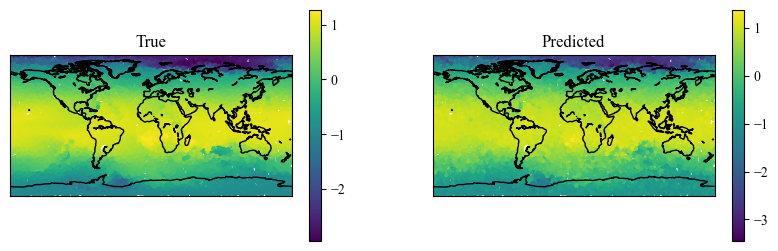

In [21]:
# plt.savefig('pra.jpg')
# import ipdb; ipdb.set_trace()
pred_model = MLP(input_dim=512, dim_hidden=64, num_layers=2, out_dims=1).float().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(pred_model.parameters(), lr=0.001)

losses = []
epochs = 100000
patience = 100  # Number of epochs with no improvement after which training will be stopped
early_stop_counter = 0  # Counter for early stopping
best_loss = None  # Best loss value

# import ipdb; ipdb.set_trace()
for epoch in range(epochs):
    optimizer.zero_grad()
    # Forward pass
    y_pred = pred_model(x_train.float().to(device))
    # Compute the loss
    loss = criterion(y_pred.reshape(-1), y_train.float().to(device))
    # Backward pass
    loss.backward()
    # Update the parameters
    optimizer.step()
    # Append the loss to the list
    losses.append(loss.item())
    if (epoch + 1) % 250 == 0:
        print(f"Epoch {epoch + 1}, MSE Loss: {loss.item():.4f}")
        print(f"Epoch {epoch + 1}, MAE Loss: {nn.L1Loss()(y_pred.reshape(-1), y_train.float().to(device)).item():.4f}")
    
        print(f"early_stop_counter: {early_stop_counter}")
    # Check for early stopping
    if best_loss is None:
        best_loss = loss.item()
    elif loss.item() < best_loss:
        best_loss = loss.item()
        early_stop_counter = 0
    else:
        early_stop_counter += 1
    if early_stop_counter >= patience:
        print("Early stopping")
        break

with torch.no_grad():
    model.eval()
    y_pred_test = pred_model(x_test.float().to(device))

# Print test loss
print(f'Test MSE loss: {criterion(y_pred_test.reshape(-1), y_test.float().to(device)).item()}')
print(f'Test MAE loss: {nn.L1Loss()(y_pred_test.reshape(-1), y_test.float().to(device)).item()}')


fig, ax = plt.subplots(1, 2, figsize=(10, 3))

m = Basemap(projection='cyl', resolution='c', ax=ax[0])
m.drawcoastlines()
scatter_true = ax[0].scatter(coords_test[:,1], coords_test[:,0], c=y_test, s=5)
ax[0].set_title('True')
fig.colorbar(scatter_true, ax=ax[0], orientation='vertical')

m = Basemap(projection='cyl', resolution='c', ax=ax[1])
m.drawcoastlines()
scatter_pred = ax[1].scatter(coords_test[:,1].cpu().numpy(), coords_test[:,0].cpu().numpy(), c=y_pred_test.reshape(-1).cpu().numpy(), s=5)
ax[1].set_title('Predicted')
fig.colorbar(scatter_pred, ax=ax[1], orientation='vertical')


In [22]:
y_test

tensor([ 1.0501,  0.9904,  1.1129,  ...,  0.7732, -0.0318, -1.2752],
       dtype=torch.float64)

[1.0226008892059326, 1.0201563835144043, 1.017837405204773, 1.015608787536621, 1.013409972190857, 1.0112411975860596, 1.0090655088424683, 1.0068418979644775, 1.0045204162597656, 1.0020508766174316, 0.9994581937789917, 0.9966965913772583, 0.9937001466751099, 0.9904546737670898, 0.986983060836792, 0.9832102060317993, 0.9790387749671936, 0.9744038581848145, 0.9692447781562805, 0.9635366797447205, 0.9572933912277222, 0.9505028128623962, 0.9431500434875488, 0.9352248907089233, 0.9266757965087891, 0.9174988865852356, 0.907670259475708, 0.8972362875938416, 0.8862789869308472, 0.8748112320899963, 0.8627723455429077, 0.8500387668609619, 0.8365157842636108, 0.8221762776374817, 0.8069536685943604, 0.7907074093818665, 0.7732741832733154, 0.7546526193618774, 0.7348842620849609, 0.7139431834220886, 0.6918704509735107, 0.6687350273132324, 0.644629716873169, 0.6196106672286987, 0.5938206315040588, 0.5672903656959534, 0.5402436852455139, 0.5129840970039368, 0.48582005500793457, 0.4591875970363617, 0.43

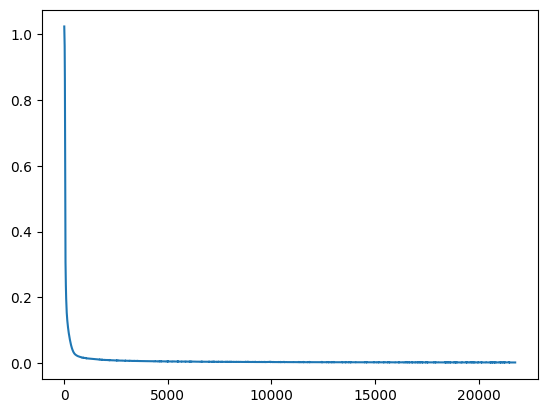

In [5]:
print(losses)
plt.plot(losses)

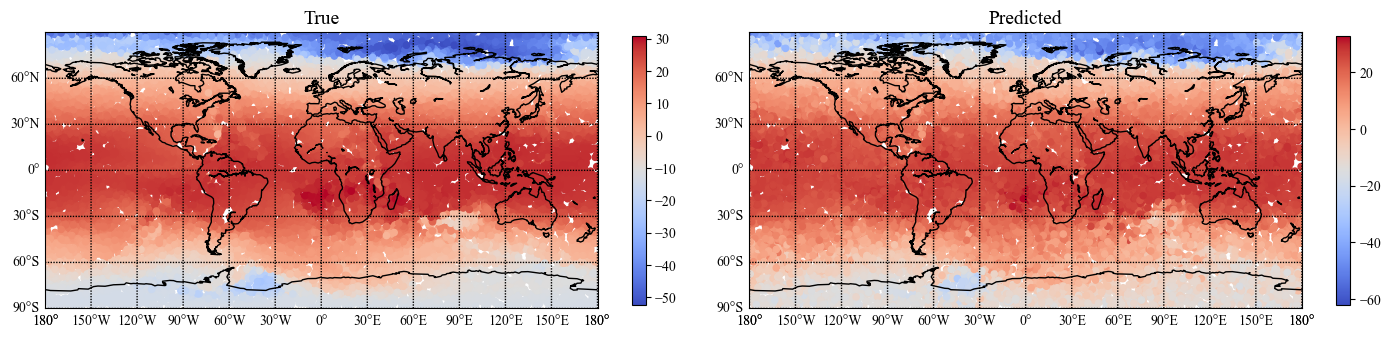

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# 设置全局字体
plt.rcParams['font.family'] = 'Times New Roman'

fig, ax = plt.subplots(1, 2, figsize=(18, 5))
y_test = y_test * y_std + y_mean
y_pred_test = y_pred_test * y_std + y_mean
m = Basemap(projection='cyl', resolution='c', ax=ax[0])
m.drawcoastlines()
m.drawmeridians(np.arange(-180, 180, 30), labels=[0,0,0,1])  # 绘制经线
m.drawparallels(np.arange(-90, 90, 30), labels=[1,0,0,0])  # 绘制纬线
scatter_true = ax[0].scatter(coords_test[:,1], coords_test[:,0], 
                             c=y_test, s=20,
                             cmap='coolwarm')
ax[0].set_title('True', fontsize=14)

# 添加颜色条
cbar_true = plt.colorbar(scatter_true, ax=ax[0], shrink=0.7)
# cbar_true.set_label('True Values', fontsize=12)

m = Basemap(projection='cyl', resolution='c', ax=ax[1])
m.drawcoastlines()
m.drawmeridians(np.arange(-180, 180, 30), labels=[0,0,0,1])  # 绘制经线
m.drawparallels(np.arange(-90, 90, 30), labels=[1,0,0,0])  # 绘制纬线
scatter_pred = ax[1].scatter(coords_test[:,1].cpu().numpy(), coords_test[:,0].cpu().numpy(), 
                             c=y_pred_test.reshape(-1).cpu().numpy(), 
                             s=20,
                             cmap='coolwarm')
ax[1].set_title('Predicted', fontsize=14)

# 添加颜色条
cbar_pred = plt.colorbar(scatter_pred, ax=ax[1], shrink=0.7)
# cbar_pred.set_label('Predicted Values', fontsize=12)
# 调整子图之间的距离
plt.subplots_adjust(wspace=0.02)
# plt.tight_layout()
plt.savefig('geoclip_airtemperature_predicted_day.pdf', dpi=1000,
            bbox_inches='tight'
            )

In [10]:
y_std

19.70961201276809